Create expected _(=averaged)_ fields from the strataero forcing file.

Note that we build three types of averaged fields, one from a WACCM control run (SSP5-8.5), one from an SAI run (Geo SSP5-8.5 1.5) and one based on the difference between both runs. Only the latter will later be fed into CAM6.

2021-12-01 Daniel Pflueger, d.pfluger@uu.nl

# Modules

In [1]:
import expected_fields as xf
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np
import norm_const_fit as nc
from scipy.optimize import curve_fit
import pandas as pd
import cftime
import geo_tools as gt
import strataero_forcing

%load_ext autoreload
%autoreload 2

# Build averaged fields

Created 2022-01-14

Load WACCM data

In [2]:
# Loading data 
# ! Edit the paths to your file paths !
path_cnt = "../data/27_05_21/ozone_strataero_WACCM_L70_zm5day_2015-2100_SSP585_c190529.nc"
path_geo = "../data/27_05_21/ozone_strataero_WACCM_L70_zm5day_2020-2100_SSP585cmip6.feedback.15C.003_c20210131.nc"

Save directories for averaged fields files

In [3]:
save_path = './exp_fields_2022_02_09/'
save_path_cnt = './exp_fields_cnt_2022_02_09/'
save_path_geo = './exp_fields_geo_2022_02_09/'
save_path_fit_params = './fit_params_2022_02_09/'

## Pre-processing

In [4]:
# Chunking/dask enabled for better performance
ds_geo_total = xr.open_dataset(path_geo,chunks={'lat':-1, 'lev':-1, 'time': 400})
ds_cnt_total = xr.open_dataset(path_cnt,chunks={'lat':-1, 'lev':-1, 'time': 400})

# Constrain data to 2020 to 2100 because there is a discontinuity afterwards
time_sel = slice('2020','2100')
ds_geo = ds_geo_total.sel(time=time_sel)
ds_cnt = ds_cnt_total.sel(time=time_sel)

# Removing irrelevant data to speed up the interpolation
ds_cnt = ds_cnt.drop_vars(['icenuc_num','NITROP_PD'])

# Interpolate the ds_cnt dataset onto the ds_geo time coordinates
# This operation will be applied to all fields in ds_cnt
# This must be done to perform the subtraction when defining ds_diff
ds_cnt = ds_cnt.interp(time=ds_geo.time)

# check that both time axis are equal
# the following line should produce a horizontal line with value 1
# (ds_cnt.time == ds_geo.time).plot() 

# this takes the difference over _all_ variables in the datasets
# including the ones we don't want to modify! I will restore these manually...
ds_diff = (ds_geo - ds_cnt)
# restore auxilliary variables
aux = ['hyai','hybi','hyam','hybm','PS','P0']
for var_name in aux:
    ds_diff[var_name].data = ds_geo[var_name].data

## Computing expected fields and norm. consts.

In [7]:
# Fields for which to compute the expected fields with their respective normalizers
# v3 note: O3 has been removed/is left in control run conditions
fields = {
    'so4mass_a1': xf.int_mass,
    'so4mass_a2': xf.int_mass,
    'so4mass_a3': xf.int_mass,
    'diamwet_a1': xf.int_l2_barometric,
    'diamwet_a2': xf.int_l2_barometric,
    'diamwet_a3': xf.int_l2_barometric,
    'SAD_AERO': xf.int_l2_barometric,
    'AODVISstdn': xf.int_aod
}
tbounds = [2070,2099]

results, results_cnt, results_geo = {}, {}, {}
for field,norm in fields.items():
    print(field)
    results[field] = xf.build_expected_field(ds_diff,field,tbounds,norm=norm,interpolate_results=True)
    results_cnt[field] = xf.build_expected_field(ds_cnt,field,tbounds,norm=norm,interpolate_results=True)
    results_geo[field] = xf.build_expected_field(ds_geo,field,tbounds,norm=norm,interpolate_results=True)

so4mass_a1
so4mass_a2
so4mass_a3
diamwet_a1
diamwet_a2
diamwet_a3
SAD_AERO
AODVISstdn


In [8]:
for field,res_dict in results.items():
    xf.save_exp(res_dict,save_path)
    
''' uncomment to save cnt & geo averaged fields 
for field,res_dict in results_cnt.items():
    xf.save_exp(res_dict,save_path_cnt)
    
for field,res_dict in results_geo.items():
    xf.save_exp(res_dict,save_path_geo)
'''

Creating parent directory ./exp_fields_2022_02_09/
Creating sub-directory ./exp_fields_2022_02_09/so4mass_a1/
Creating sub-directory ./exp_fields_2022_02_09/so4mass_a2/
Creating sub-directory ./exp_fields_2022_02_09/so4mass_a3/
Creating sub-directory ./exp_fields_2022_02_09/diamwet_a1/
Creating sub-directory ./exp_fields_2022_02_09/diamwet_a2/
Creating sub-directory ./exp_fields_2022_02_09/diamwet_a3/
Creating sub-directory ./exp_fields_2022_02_09/SAD_AERO/
Creating sub-directory ./exp_fields_2022_02_09/AODVISstdn/
Creating parent directory ./exp_fields_cnt_2022_02_09/
Creating sub-directory ./exp_fields_cnt_2022_02_09/so4mass_a1/
Creating sub-directory ./exp_fields_cnt_2022_02_09/so4mass_a2/
Creating sub-directory ./exp_fields_cnt_2022_02_09/so4mass_a3/
Creating sub-directory ./exp_fields_cnt_2022_02_09/diamwet_a1/
Creating sub-directory ./exp_fields_cnt_2022_02_09/diamwet_a2/
Creating sub-directory ./exp_fields_cnt_2022_02_09/diamwet_a3/
Creating sub-directory ./exp_fields_cnt_2022_0

## Plotting norm. consts. vs AOD

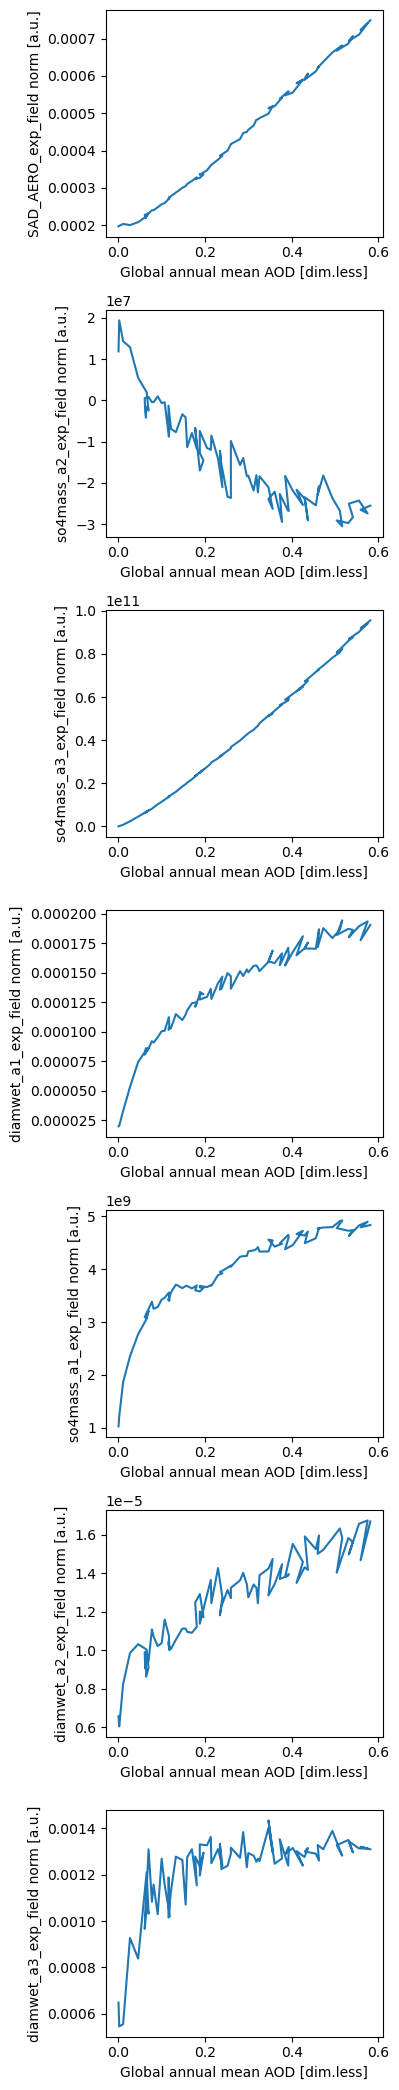

In [9]:
results = xf.load_exp(save_path)

aod = results['AODVISstdn']
results.pop('AODVISstdn') # removes 'AODVISstdn' in-place

fig, axes = plt.subplots(nrows=len(results),figsize=(4.0,3.0*len(results)))
for (name,res_dict),ax in zip(results.items(),axes):
    ax.plot(aod['n'],res_dict['n'])
    ax.set_xlabel('Global annual mean AOD [dim.less]')
    name = res_dict['exp_field'].name
    ax.set_ylabel(f'{name} norm [a.u.]')
plt.tight_layout()

## Fitting norm constants

### aux 

In [13]:
def estimate_p0_linear(norm):
    '''
    - use initial and final norm as estimate for slope of a linear fit
    - obtain initial parameters for nc.fit_func_power_law
    '''
    
    ti, tf = norm.year[0], norm.year[-1]
    ni, nf = norm.data[0], norm.data[-1]
    
    a = ni
    b = float((nf-ni)/(tf-ti))
    c = 1
    
    return [a,b,c]

def estimate_p0_saturate(norm):
    '''
    - obtain initial parameters for nc.fit_func_saturate
    '''
    pass
    
results = xf.load_exp(save_path)

# extract the norm constants from 'results'
main_name = 'AODVISstdn'
names = list(results.keys())
names.remove(main_name)
results_n = {}
for name in names:
    results_n[name] = results[name]['n']

# Prepare the fitting options for all norm constant fits
options = {}
for name,norm in results_n.items():
    options[name] = {}
    options[name]['p0'] = estimate_p0_linear(norm)
    
# Treat the diamwet fields separately: throw away the first 10 years of data
# They behave anomalously and complicate the fit
for name in ['diamwet_a1','diamwet_a2','diamwet_a3']:
    options[name]['tbounds'] = [2030,2100]

options['diamwet_a3']['fit_func'] = nc.fit_func_saturate
options['diamwet_a3']['p0'] = p0_2 = [0.0014, -0.02, -20, -0.1]

### Fit, plot & save

SAD_AERO
so4mass_a2
so4mass_a3
diamwet_a1
so4mass_a1
diamwet_a2
diamwet_a3


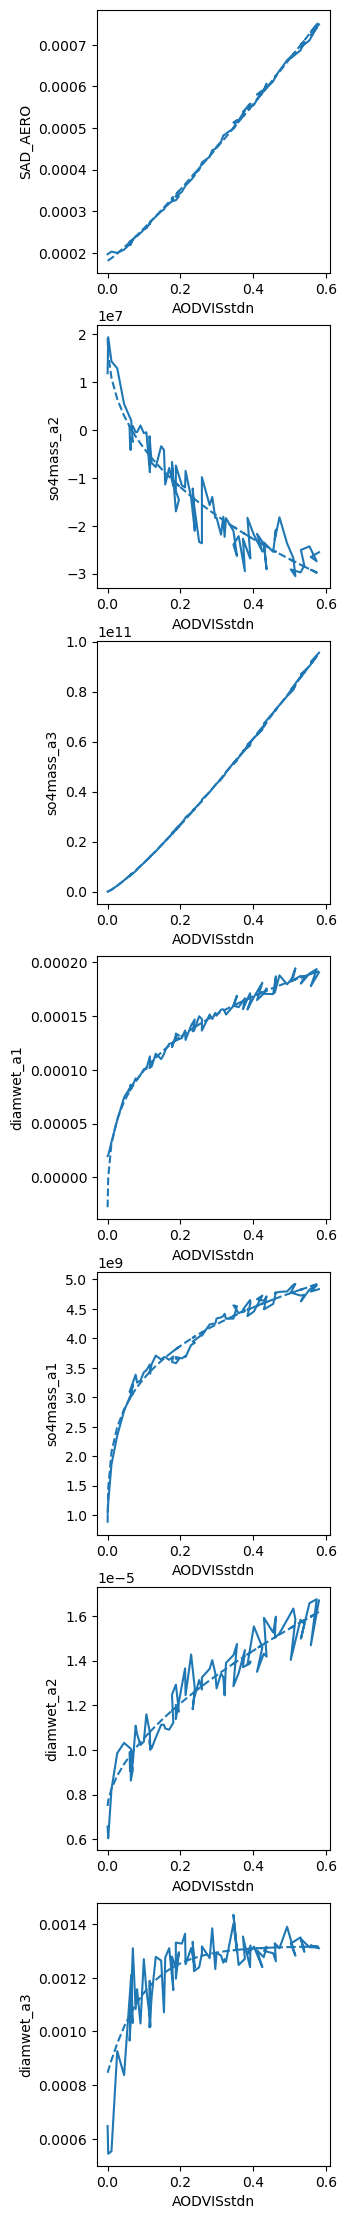

In [14]:
fit_results = nc.fit_norm_const(results,'AODVISstdn',options=options)
nc.plot_fit_results(results,fit_results,options,'AODVISstdn')
nc.save_fit(fit_results,save_path_fit_params,options)

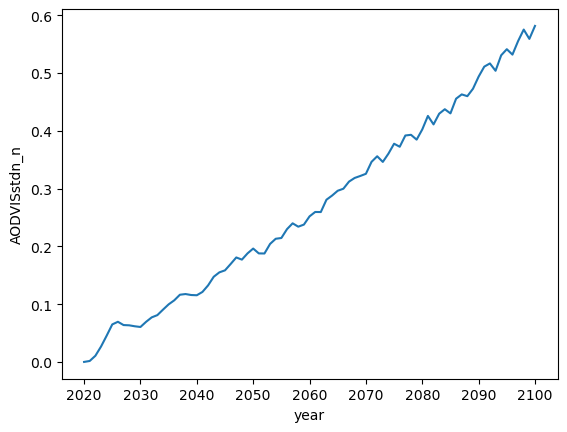

In [15]:
results['AODVISstdn']['n'].plot()

## Some exploration

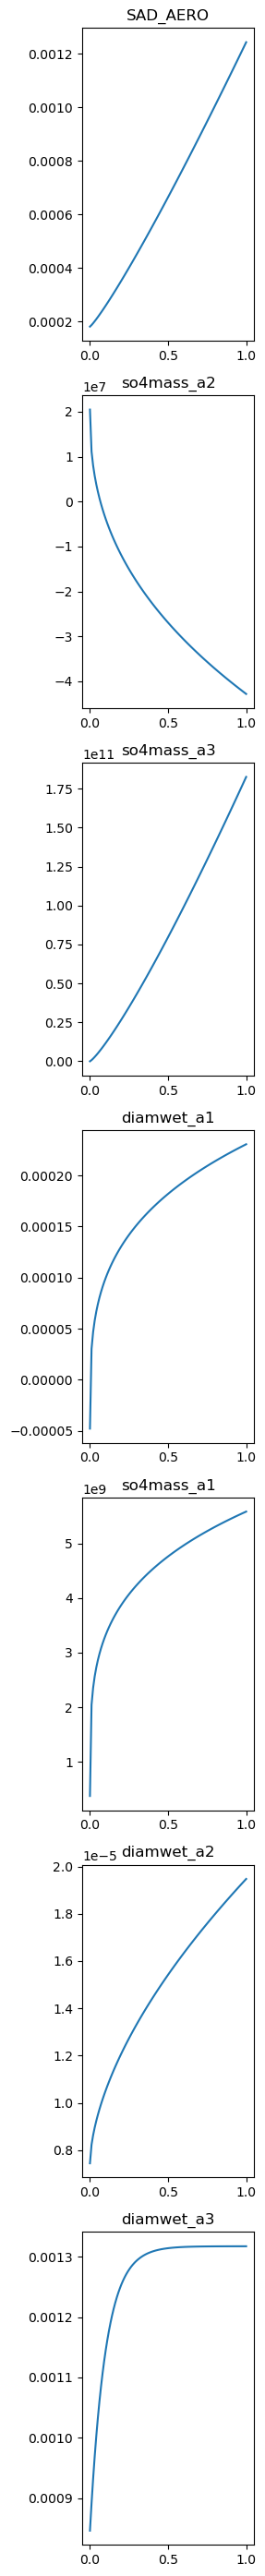

In [16]:
# Extend fits for AOD range 0.0 to 1.0

aod_range = np.linspace(0,1,100)
no_plots = len(fit_results.keys())
fig, axes = plt.subplots(nrows=no_plots,figsize=(3,4*no_plots))

for name,ax in zip(fit_results,axes):
    ns = options[name]['fit_func'](aod_range,*fit_results[name]['popt'])
    ax.plot(aod_range,ns)
    ax.set_title(name)
    
plt.tight_layout()

In [17]:
options

{'SAD_AERO': {'p0': [0.00019703811455973496, 6.900017845988077e-06, 1],
  'tbounds': [array(2020), array(2100)],
  'fit_func': <function norm_const_fit.fit_func_power_law(x, a, b, c)>,
  'kwargs': {}},
 'so4mass_a2': {'p0': [11883775.194471069, -467732.00316785555, 1],
  'tbounds': [array(2020), array(2100)],
  'fit_func': <function norm_const_fit.fit_func_power_law(x, a, b, c)>,
  'kwargs': {}},
 'so4mass_a3': {'p0': [24972247.8674287, 1194191532.0521078, 1],
  'tbounds': [array(2020), array(2100)],
  'fit_func': <function norm_const_fit.fit_func_power_law(x, a, b, c)>,
  'kwargs': {}},
 'diamwet_a1': {'p0': [1.9727493672525486e-05, 2.1374405635207228e-06, 1],
  'tbounds': [2030, 2100],
  'fit_func': <function norm_const_fit.fit_func_power_law(x, a, b, c)>,
  'kwargs': {}},
 'so4mass_a1': {'p0': [1023346260.7378365, 47660892.70829458, 1],
  'tbounds': [array(2020), array(2100)],
  'fit_func': <function norm_const_fit.fit_func_power_law(x, a, b, c)>,
  'kwargs': {}},
 'diamwet_a2': {'p

In [18]:
results_cnt = xf.load_exp('./exp_fields_cnt_2022_02_09/')
results_geo = xf.load_exp('./exp_fields_geo_2022_02_09/')
results = xf.load_exp('./exp_fields_2022_02_09/')

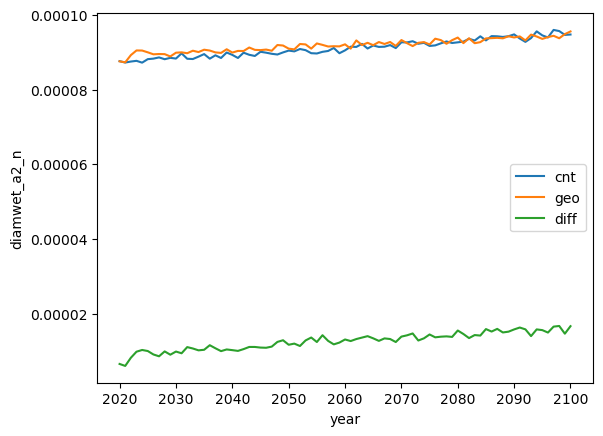

In [19]:
results_cnt['diamwet_a2']['n'].plot(label='cnt')
results_geo['diamwet_a2']['n'].plot(label='geo')
results['diamwet_a2']['n'].plot(label='diff')
plt.legend()

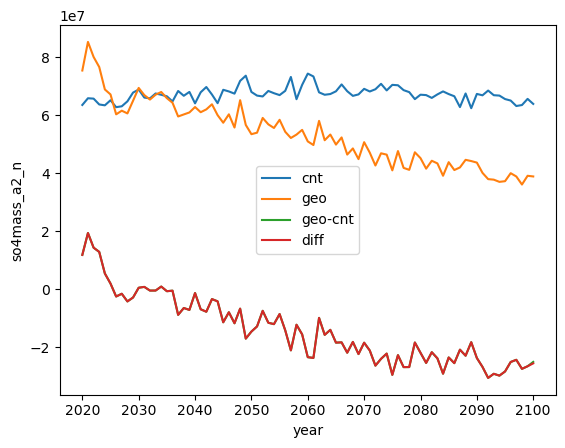

In [20]:
results_cnt['so4mass_a2']['n'].plot(label='cnt')
results_geo['so4mass_a2']['n'].plot(label='geo')
(results_geo['so4mass_a2']['n']-results_cnt['so4mass_a2']['n']).plot(label='geo-cnt')
results['so4mass_a2']['n'].plot(label='diff')
plt.legend()